In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(13407, 28)
(13407, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_motion[:, 24] == 1)[0]
X_motion_RR_swinging = X_motion[idxs]
Y_motion_RR_swinging = Y_motion[idxs]

## Predict RR foot -> x

In [8]:
X_motion_RR_swinging[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.00705461, -0.0678609 ,
        0.03265411, -0.01573039,  0.0129401 ,  0.0179059 ,  0.23796512,
        0.18857408, -0.43054778,  0.23416019, -0.17137044, -0.43118574,
       -0.25060634,  0.16185945, -0.42817544, -0.25850497, -0.13664885,
       -0.4303694 ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.1       ,  0.        ,  0.        ])

In [9]:
Y_motion_RR_swinging[0, :]

array([ 0.01467272,  0.00178522,  0.02469857, -0.00701681])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # prev velocity command
               X_motion_RR_swinging[:, -3:], # commanded velocity command
               X_motion_RR_swinging[:, 9:11], # FL (x,y) position
               X_motion_RR_swinging[:, 12:14], # FR (x,y) position
               X_motion_RR_swinging[:, 15:17], # RL (x,y) position
               X_motion_RR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9946009578079328
RMSE:  0.003907264174270383
The lowest error is:  1.288253952874685e-06
The highest error is:  0.05159568940535217
The avg. error is:  0.0023747994243387277


In [11]:
model_rr_relative_swinging_x.coef_

array([[-2.46219073e-03,  5.55111512e-17, -8.32667268e-17,
         2.08064357e-01,  1.11022302e-16, -2.08166817e-17,
         1.13557360e-01,  4.83607876e-02,  2.11471197e-01,
        -2.95806067e-01,  1.95209251e-02,  1.01482351e-01,
        -3.64389103e-01,  5.91131650e-02]])

In [12]:
model_rr_relative_swinging_x.intercept_

array([-0.23219317])

Text(0, 0.5, 'Predictions')

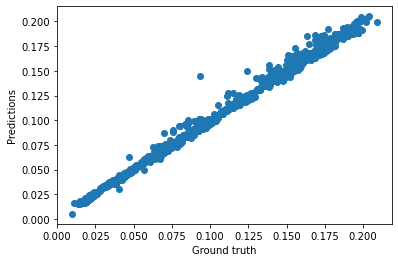

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_rr_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [17]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # prev velocity command
               X_motion_RR_swinging[:, -3:], # commanded velocity command
               X_motion_RR_swinging[:, 9:11], # FL (x,y) position
               X_motion_RR_swinging[:, 12:14], # FR (x,y) position
               X_motion_RR_swinging[:, 15:17], # RL (x,y) position
               X_motion_RR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.7601254088280744
RMSE:  0.004078675279104256
The lowest error is:  3.447094821668051e-07
The highest error is:  0.040943010896385856
The avg. error is:  0.002739315101972007


In [18]:
model_rr_relative_swinging_y.coef_

array([[ 6.80595417e-03,  1.73472348e-18,  1.11022302e-16,
         3.31319350e-02, -4.16333634e-17, -5.55111512e-17,
         4.94853543e-02,  1.45456490e-01, -4.55523656e-01,
        -1.04100301e-01,  2.67918883e-01, -2.05333479e-01,
         9.14386160e-02, -4.85526816e-01]])

In [19]:
model_rr_relative_swinging_y.intercept_

array([0.09578824])

Text(0, 0.5, 'Predictions')

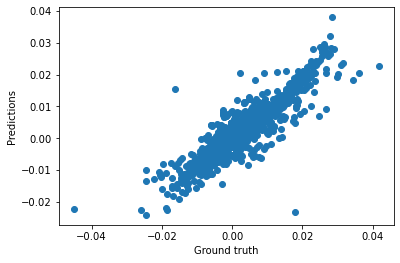

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_rr_relative_swinging_y

In [30]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [31]:
# Save model
#joblib.dump(model_rr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_y.sav")